In [1]:
import os, glob
import numpy as np
#import matplotlib.pyplot as plt
import tensorflow as tf
import random
import cv2
from tensorflow import keras
from keras.losses import CategoricalCrossentropy
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam

from tifffile import imread, imwrite

c:\Users\nwuen\.conda\envs\tensorflow\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


import pandas as pd 
labels = pd.read_pickle(f'{os.environ["HOME"]}/Dokumente/AML Projekt/labels_pkl/labels.pkl')
for i in range(len(labels)): ##über len(labels)
    im_old = imread(f'{os.environ["HOME"]}/Dokumente/AML Projekt/cropped_labels/{labels["img_folder"][i]}/{os.path.splitext(labels["img_name"][i])[0]}.tif')
    im_new = to_categorical(im_old)
    imwrite(f'{os.environ["HOME"]}/Dokumente/AML Projekt/categorical_labels/{labels["img_folder"][i]}/{os.path.splitext(labels["img_name"][i])[0]}.tif',im_new)

In [2]:
epochs = 1000
num_batches = 250
batch_size = 2

patch_size = 800

num_classes = 44
classes = np.arange(44)
scores = [ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 24., 25., 26.,
       27., 28., 30., 32., 33., 34., 36., 38., 39., 40., 42., 45., 48.,
       50., 51., 54., 57., 60.]


class MyLRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, initial_learning_rate):
    self.initial_learning_rate = initial_learning_rate

  def __call__(self, epoch):
    return self.initial_learning_rate*( 1- epoch/epochs)**0.9

optimizer = keras.optimizers.SGD(MyLRSchedule(0.01),momentum=0.99,nesterov=True, name='SGD')
#optimizer = Adam(learning_rate=3e-4)

#class MyLoss(tf.keras.losses.Loss):
def MyLoss(targets, prediction):
    
    intersection = keras.backend.sum(tf.cast(targets*prediction,tf.float32),axis=(1,2))
    dice = (-2/num_classes)*keras.backend.sum(intersection/(keras.backend.sum(targets,axis=(1,2)) + keras.backend.sum(prediction,axis=(1,2))),axis=1)
    Crossentropy = CategoricalCrossentropy()(targets,prediction)

    return dice + Crossentropy

In [3]:
def load_label(path_to_label):

    label = imread(path_to_label)
    
    for i, score in enumerate(scores):
        label[label == score] = i

    label = to_categorical(label,num_classes)

    return label

In [4]:
def load_training_data(img_dir, label_dir,batch_number=0):
    
    # get filenames
    img_names = sorted(glob.glob(img_dir+'/**/*'+'.JPG', recursive=True))
    label_names = sorted(glob.glob(label_dir+'/**/*'+'.tif', recursive=True))

    # Initalise mini batch
    images = np.zeros((batch_size,patch_size,patch_size,3))
    labels = np.zeros((batch_size,patch_size,patch_size,num_classes))

    batch_start = batch_number*batch_size
    batch_end = batch_start + batch_size

    if batch_start >= len(img_names):
        batch_start = batch_start%len(img_names)
        batch_end = batch_start +batch_size
    if batch_end >=len(img_names):
        batch_end = len(img_names)

    for i, (img_name, label_name) in enumerate(zip(img_names[batch_start:batch_end], label_names[batch_start:batch_end])):

        x = random.randint(0,800-patch_size)
        y = random.randint(0,800-patch_size)

        # append label
        labels[i] = load_label(label_name)[x:x+patch_size,y:y+patch_size]

        # append image
        new_img = cv2.imread(img_name)[x:x+patch_size,y:y+patch_size].astype(np.float32)
        new_img -= np.mean(new_img)
        new_img /= np.var(new_img)
        images[i] = new_img
        

    return images, labels

In [5]:
train_img_path = 'C:/Users/nwuen/Documents/deepdart_aml/dataset/cropped_images/800/d1_02_04_2020'
train_label_path = 'T:/deepdart_data/d1_02_04_2020'

val_img_path = 'C:/Users/nwuen/Documents/deepdart_aml/dataset/cropped_images/800/d1_02_06_2020'
val_label_path = 'T:/deepdart_data/d1_02_06_2020'

In [6]:
from keras.layers import MaxPooling2D, Conv2D, Conv2DTranspose, concatenate ,BatchNormalization, LeakyReLU

Norm = BatchNormalization
LReLU = LeakyReLU
Pool = MaxPooling2D

def NN_UNet():
    inputs = keras.Input(shape=(patch_size,patch_size,3))

    #Downsampeling
    x = Conv2D(32,3,padding='same')(inputs)
    x = Norm()(x)
    x = LReLU(alpha= 0.01)(x)

    x = Conv2D(32,3,padding='same')(x)
    x = Norm()(x)
    l1 = LReLU(alpha= 0.01)(x)

    x = Pool(pool_size=2, strides= 2, padding='valid')(l1)

    x = Conv2D(64,3,padding='same')(x)
    x = Norm()(x)
    x = LReLU(alpha= 0.01)(x)

    x = Conv2D(64,3,padding='same')(x)
    x = Norm()(x)
    l2 = LReLU(alpha= 0.01)(x)

    x = Pool(pool_size= 2, strides= 2, padding='valid')(l2)

    x = Conv2D(128,3,padding='same')(x)
    x = Norm()(x)
    x = LReLU(alpha= 0.01)(x)

    x = Conv2D(128,3,padding='same')(x)
    x = Norm()(x)
    l3 = LReLU(alpha= 0.01)(x)
    
    x = Pool(pool_size= 2, strides= 2, padding='valid')(l3)

    x = Conv2D(256,3,padding='same')(x)
    x = Norm()(x)
    x = LReLU(alpha= 0.01)(x)

    x = Conv2D(256,3,padding='same')(x)
    x = Norm()(x)
    l4 = LReLU(alpha= 0.01)(x)
    
    

    x = Conv2DTranspose(128,3,2,padding='same')(l4)
    x = concatenate([x,l3])
    
    x = Conv2D(128,3,padding='same')(x)
    x = Norm()(x)
    x = LReLU(alpha= 0.01)(x)

    x = Conv2D(128,3,padding='same')(x)
    x = Norm()(x)
    x = LReLU(alpha= 0.01)(x)
    
    x = Conv2DTranspose(64,3,2,padding='same')(x)
    x = concatenate([x,l2])

    x = Conv2D(64,3,padding='same')(x)
    x = Norm()(x)
    x = LReLU(alpha= 0.01)(x)

    x = Conv2D(64,3,padding='same')(x)
    x = Norm()(x)
    x = LReLU(alpha= 0.01)(x)

    x = Conv2DTranspose(32,3,2,padding='same')(x)
    x = concatenate([x,l1])

    x = Conv2D(32,3,padding='same')(x)
    x = Norm()(x)
    x = LReLU(alpha= 0.01)(x)

    x = Conv2D(32,3,padding='same')(x)
    x = Norm()(x)
    x = LReLU(alpha= 0.01)(x)

    x = Conv2D(44,1)(x)
    outputs = keras.activations.softmax(x)

    model = keras.Model(inputs,outputs,name='U-Net')
    return model

UNet = NN_UNet()
UNet.summary()


Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 800, 800, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 800, 800, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 800, 800, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [7]:
UNet.compile(
    loss = MyLoss,
    optimizer = optimizer,
    metrics=["accuracy"]
)

'''
x_train, y_train = load_training_data(train_img_path,train_label_path,0)
x_val, y_val = load_training_data(val_img_path,val_label_path,0)

history = UNet.fit(x=x_train,y=y_train,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(x_val,y_val))
'''


for epoch in range(epochs):
    print(f'Start of Epoch {epoch+1}\n')
    for i in range(num_batches):

        with tf.GradientTape() as tape:
            #load the data to train and validate

            x_train, y_train = load_training_data(train_img_path,train_label_path,i)
            x_val, y_val = load_training_data(val_img_path,val_label_path,i)

            logits = UNet(x_train,training=True)
            loss_value = MyLoss(y_train,logits)
        grads = tape.gradient(loss_value, UNet.trainable_weights)
        optimizer.apply_gradients(zip(grads, UNet.trainable_weights))

                # Log every 200 batches.
        if i % 5 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (i, float(loss_value))
            )
            print("Seen so far: %s samples" % ((i + 1) * batch_size))

        #history = UNet.fit(x=x_train,y=y_train,batch_size=batch_size,epochs=1,verbose=1,validation_data=(x_val,y_val))
    #test_scores = model.evaluate(x_test,y_test,verbose=2)


Start of Epoch 1



ResourceExhaustedError: Exception encountered when calling layer "conv2d_3" (type Conv2D).

OOM when allocating tensor with shape[8,64,400,400] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2D]

Call arguments received by layer "conv2d_3" (type Conv2D):
  • inputs=tf.Tensor(shape=(8, 400, 400, 64), dtype=float32)

In [ ]:
train = UNet.predict(x_train)[0]
train = np.argmax(train,axis=2)
for i, score in enumerate(scores):
    train[train==i] = score

test = UNet.predict(x_val)[0]
test = np.argmax(test,axis=2)
for i, score in enumerate(scores):
    test[test==i] = score


1/1 [==============================] - 2s 2s/step


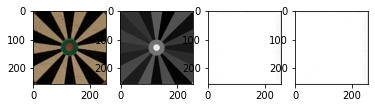

In [ ]:
fig, axs = plt.subplots(1,4)
axs[0].imshow(plt.imread('T:/deepdart_data/cropped_images/800/d1_02_04_2020/IMG_1081.JPG')[400-128:400+128,400-128:400+128])
axs[1].imshow(np.dot(y_train[0],scores),cmap='gray')
axs[2].imshow(train,cmap='gray')
axs[3].imshow(test,cmap='gray')
plt.show()
plt.imsave('test.png',train,cmap='gray')

In [ ]:
import pandas as pd
import os 

pd.read_pickle(f'{os.environ["HOME"]}/Dokumente/deepdart_aml/labelswithscore.pkl')

,img_folder,img_name,bbox,xy,score
0,d1_02_04_2020,IMG_1081.JPG,"[2297, 3949, 676, 2328]","[[0.4350282485875706, 0.1285310734463277], [0....",0.0
1,d1_02_04_2020,IMG_1082.JPG,"[2267, 3803, 759, 2295]","[[0.44162326388888884, 0.12738715277777776], [...",20.0
2,d1_02_04_2020,IMG_1083.JPG,"[2267, 3803, 759, 2295]","[[0.44162326388888884, 0.12738715277777776], [...",29.0
3,d1_02_04_2020,IMG_1084.JPG,"[2267, 3803, 759, 2295]","[[0.44162326388888884, 0.12738715277777776], [...",69.0
4,d1_02_04_2020,IMG_1085.JPG,"[2267, 3803, 759, 2295]","[[0.44162326388888884, 0.12738715277777776], [...",7.0
...,...,...,...,...,...
16045,d2_04_05_2020,DSC_0507.JPG,"[200, 2849, 969, 3618]","[[0.4369087750204756, 0.1419047415543067], [0....",27.0
16046,d2_04_05_2020,DSC_0508.JPG,"[200, 2849, 969, 3618]","[[0.4369087750204756, 0.1419047415543067], [0....",34.0
16047,d2_04_05_2020,DSC_0509.JPG,"[200, 2849, 969, 3618]","[[0.4369087750204756, 0.1419047415543067], [0....",1.0
16048,d2_04_05_2020,DSC_0510.JPG,"[200, 2849, 969, 3618]","[[0.4369087750204756, 0.1419047415543067], [0....",21.0
